In [1]:
from src.data_preprocessor import DataProcessor
from data_configs.configs import *
from models.neural_networks import *
from src.cross_validation import CrossValidation
import numpy as np

config = car_config
data_processor = DataProcessor(config=config)
cross_validator = CrossValidation(config=config)

In [2]:
raw_data = data_processor.load_data()
data_1 = data_processor.impute_missing_values(raw_data)
data_2 = data_processor.encode_ordinal_features(data_1)
data_3 = data_processor.standardize_data(data_2,data_2,features=['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety'])

c:\Users\Srikanta\Documents\Intro to Machine Learning\programming_assignment_1\src\data_preprocessor.py:47: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[column].fillna(data[column].mode()[0], inplace=True)


In [3]:
data_3

,buying,maint,doors,persons,lug_boot,safety,Class
0,-1.341253,-1.341253,-1.341253,-1.22439,-1.22439,-1.22439,unacc
1,-1.341253,-1.341253,-1.341253,-1.22439,-1.22439,0.00000,unacc
2,-1.341253,-1.341253,-1.341253,-1.22439,-1.22439,1.22439,unacc
3,-1.341253,-1.341253,-1.341253,-1.22439,0.00000,-1.22439,unacc
4,-1.341253,-1.341253,-1.341253,-1.22439,0.00000,0.00000,unacc
...,...,...,...,...,...,...,...
1723,1.341253,1.341253,1.341253,1.22439,0.00000,0.00000,good
1724,1.341253,1.341253,1.341253,1.22439,0.00000,1.22439,vgood
1725,1.341253,1.341253,1.341253,1.22439,1.22439,-1.22439,unacc
1726,1.341253,1.341253,1.341253,1.22439,1.22439,0.00000,good


In [4]:
data_train, data_val = cross_validator.random_partition(data_3, random_state=42)

In [5]:
data_val = data_processor.encode_nominal_features(data_val)

In [6]:
data_val

,buying,maint,doors,persons,lug_boot,safety,Class_acc,Class_good,Class_unacc,Class_vgood
599,-0.447084,-0.447084,0.447084,-1.22439,0.00000,1.22439,0,0,1,0
1201,0.447084,1.341253,-1.341253,0.00000,0.00000,0.00000,1,0,0,0
628,-0.447084,-0.447084,1.341253,-1.22439,1.22439,0.00000,0,0,1,0
1498,1.341253,-0.447084,1.341253,0.00000,0.00000,0.00000,1,0,0,0
1263,0.447084,1.341253,0.447084,1.22439,0.00000,-1.22439,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
100,-1.341253,-1.341253,1.341253,1.22439,-1.22439,0.00000,0,0,1,0
274,-1.341253,0.447084,0.447084,-1.22439,0.00000,0.00000,0,0,1,0
1206,0.447084,1.341253,-1.341253,1.22439,-1.22439,-1.22439,0,0,1,0
101,-1.341253,-1.341253,1.341253,1.22439,-1.22439,1.22439,0,0,1,0


In [7]:
best_params_linear = {'lr': 0.001, 'epochs': 17000}
best_params_ffn = {'lr': 0.0001, 'epochs': 15000, 'n_hidden': 50}
best_params_auto = {'lr': 0.0001, 'epochs': 15000, 'n_encoder': 4}
best_params_combined = {'lr': 0.001, 'epochs': 19000, 'n_hidden_2': 40}

## One Fold Cross-Validation ##

In [8]:
linear_scores = []
ffn_scores = []
combined_scores = []

for i, (train_set, test_set) in enumerate(cross_validator.cross_validation(data_train, n_splits=2, n_repeats=1, random_state=42, stratify=True)):

    train_set = data_processor.encode_nominal_features(train_set)
    test_set = data_processor.encode_nominal_features(test_set)

    train_data = train_set.to_numpy()
    X_train = train_data[:,:-4]
    y_train = train_data[:,-4:]

    test_data = test_set.to_numpy()
    X_test = test_data[:,:-4]
    y_test = test_data[:,-4:]

    linear = LinearNetwork(config)
    _, linear_val_losses = linear.logistic_regression(X_train,y_train,X_test,y_test,epochs=best_params_linear['epochs'],lr=best_params_linear['lr'],patience=500)

    ffn = FeedForwardNetwork(config,n_input=X_train.shape[1],n_hidden_1=best_params_ffn['n_hidden'],n_hidden_2=best_params_ffn['n_hidden'],n_output=y_train.shape[1])
    _, ffn_val_losses, _ = ffn.train(X_train,y_train,X_test,y_test,epochs=best_params_ffn['epochs'],lr=best_params_ffn['lr'],patience=500)

    autoE = AutoEncoder(config,n_input=X_train.shape[1],n_encoder=best_params_auto['n_encoder'])
    losses = autoE.train(X_train, max_epochs=best_params_auto['epochs'], lr=best_params_auto['lr'])
    combined = CombinedModel(autoE,n_hidden_2=best_params_combined['n_hidden_2'],n_output=y_test.shape[1])
    _, combined_val_losses, _ = combined.train(X_train,y_train,X_test,y_test,epochs=best_params_combined['epochs'], lr=best_params_combined['lr'],patience=500)


    linear_score = np.min(linear_val_losses)
    ffn_score = np.min(ffn_val_losses)
    combined_score = np.min(combined_val_losses)
    
    linear_scores.append(linear_score)
    ffn_scores.append(ffn_score)
    combined_scores.append(combined_score)

avg_score_linear = np.mean(linear_scores)
avg_score_ffn = np.mean(ffn_scores)
avg_score_combined = np.mean(combined_scores)

print(f"Linear Model Tested params: {best_params_linear}, Average Score: {avg_score_linear}")
print(f"FFN Model Tested params: {best_params_ffn}, Average Score: {avg_score_ffn}")
print(f"Combined Model Tested params: {best_params_combined}, Average Score: {avg_score_combined}")

Linear Model Tested params: {'lr': 0.001, 'epochs': 17000}, Average Score: 0.4013790070896668
FFN Model Tested params: {'lr': 0.0001, 'epochs': 15000, 'n_hidden': 50}, Average Score: 0.07533373028744057
Combined Model Tested params: {'lr': 0.001, 'epochs': 19000, 'n_hidden_2': 40}, Average Score: 0.13289618117734572


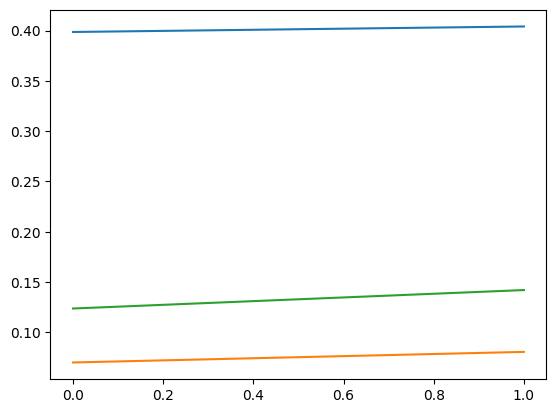

In [16]:
import matplotlib.pyplot as plt

plt.plot(linear_scores)
plt.plot(ffn_scores)
plt.plot(combined_scores)

## Forward Propagation and Back Propagation ##

### Linear Model ###

In [10]:
linear = LinearNetwork(config)

losses, val_losses = linear.logistic_regression(X_train,y_train,X_test,y_test,epochs=2,lr=best_params_linear['lr'],patience=np.inf,verbose=True)

Initial Weights:
 [[0.00446055 0.00323912 0.00831545 0.00809626]
 [0.00175728 0.00453764 0.00084118 0.00056452]
 [0.00404031 0.00026058 0.00963457 0.00013669]
 [0.00847414 0.00886973 0.00477701 0.00170167]
 [0.00994896 0.00957061 0.00291931 0.00886868]
 [0.00034229 0.00680761 0.00040041 0.00991561]
 [0.00120173 0.00130615 0.00071035 0.00259252]]
X*W =
 [[ 0.02212238  0.03035262  0.00560638  0.03561167]
 [ 0.0133116   0.01978754  0.02655887  0.01577522]
 [-0.0029115  -0.00642573  0.01080818 -0.00219296]
 ...
 [ 0.03463175  0.0375672   0.03208572  0.03381364]
 [-0.00380071 -0.00687908  0.00320731 -0.01344621]
 [ 0.01502622  0.00480179  0.01394739  0.00636712]]

Softmax(X*W) =
 [[0.24965893 0.25172217 0.24556943 0.25304947]
 [0.24861404 0.25022927 0.25192941 0.24922728]
 [0.24931283 0.24843823 0.2527569  0.24949204]
 ...
 [0.2500263  0.25076132 0.24939054 0.24982184]
 [0.25035301 0.24958351 0.25211365 0.24794984]
 [0.25124822 0.24869244 0.25097731 0.24908203]]

Error =
 [[-0.24965893 -0.2

### FFN Model ###

In [11]:
ffn = FeedForwardNetwork(config,n_input=X_train.shape[1],n_hidden_1=5,n_hidden_2=5,n_output=y_train.shape[1],verbose=True)
 
metrics, val_metrics, final_metric = ffn.train(X_train,y_train,X_test,y_test,epochs=2,lr=best_params_ffn['lr'],patience=np.inf)

Hidden Layer 1 Weights:
 [[9.14555964e-03 9.02107984e-03 1.02110885e-03 2.46941514e-05
  8.07650099e-03]
 [8.78559727e-03 7.44875777e-03 3.37945023e-04 9.01725594e-03
  3.31404290e-03]
 [6.94623881e-03 1.03687555e-03 5.11046717e-03 1.80693292e-03
  6.24299679e-03]
 [5.62732269e-03 1.49201670e-04 2.64474080e-03 8.53182389e-03
  6.43102594e-03]
 [6.63628088e-03 5.51082017e-04 9.84589274e-03 3.56769289e-03
  9.19068313e-03]
 [1.13424473e-03 5.84709872e-03 2.61846916e-04 7.04291106e-03
  4.96378305e-03]]

Hidden Layer 2 Weights:
 [[0.00402463 0.00856175 0.00699011 0.00027559 0.00054404]
 [0.00071146 0.00717461 0.00761011 0.00670066 0.00859768]
 [0.00028546 0.00559017 0.00508597 0.00123926 0.00195506]
 [0.00244397 0.00334034 0.00155638 0.00130922 0.00573794]
 [0.00589907 0.00553872 0.00067009 0.00353963 0.0084731 ]]

Output Layer Weights:
 [[0.00968621 0.00085368 0.00681911 0.0075328 ]
 [0.00713899 0.00510209 0.00809516 0.00127928]
 [0.0085573  0.00633241 0.00678873 0.00904508]
 [0.00067794

### Autoencoder Model ###

In [28]:
autoE = AutoEncoder(config,n_input=X_train.shape[1],n_encoder=best_params_auto['n_encoder'],verbose=True)
losses = autoE.train(X_train, max_epochs=2, lr=best_params_auto['lr'])

Initial Encoder Weights:
[[0.00114302 0.00296262 0.0032355  0.00578904]
 [0.00825401 0.00237674 0.00046043 0.00625786]
 [0.00468365 0.00357627 0.00807853 0.0004185 ]
 [0.00812117 0.00396022 0.00128349 0.00551117]
 [0.00945245 0.0047531  0.00143235 0.00643536]
 [0.00531645 0.00377731 0.00141302 0.00172905]]

Initial Decoder Weights:
[[0.00018379 0.00629444 0.00685309 0.00236229 0.00505592 0.00332206]
 [0.00547388 0.00279516 0.00362544 0.00615789 0.00411428 0.00855833]
 [0.00321571 0.00080174 0.00047602 0.0058993  0.00502324 0.00452646]
 [0.00803677 0.00605406 0.00862847 0.00077716 0.00434239 0.00276789]]

Initial Encoder Biases:
[[0.00114302 0.00296262 0.0032355  0.00578904]
 [0.00825401 0.00237674 0.00046043 0.00625786]
 [0.00468365 0.00357627 0.00807853 0.0004185 ]
 [0.00812117 0.00396022 0.00128349 0.00551117]
 [0.00945245 0.0047531  0.00143235 0.00643536]
 [0.00531645 0.00377731 0.00141302 0.00172905]]

Initial Decoder Biases:
[[0.00018379 0.00629444 0.00685309 0.00236229 0.00505592

In [29]:
import pandas as pd

_, Output = autoE.forward_pass(X_train)
pd.DataFrame(Output)

,0,1,2,3,4,5
0,0.006018,-0.004923,0.011807,0.013751,0.002294,0.005554
1,0.006065,-0.004908,0.011870,0.013791,0.002321,0.005581
2,0.005978,-0.004942,0.011718,0.013666,0.002245,0.005492
3,0.005958,-0.004946,0.011680,0.013620,0.002221,0.005460
4,0.006005,-0.004927,0.011774,0.013710,0.002272,0.005525
...,...,...,...,...,...,...
686,0.006008,-0.004921,0.011763,0.013665,0.002254,0.005495
687,0.006005,-0.004917,0.011769,0.013670,0.002257,0.005500
688,0.006077,-0.004892,0.011908,0.013809,0.002336,0.005595
689,0.005974,-0.004960,0.011678,0.013648,0.002229,0.005478


In [27]:
pd.DataFrame(X_train)

,0,1,2,3,4,5
0,-1.341253,-1.341253,1.341253,1.22439,1.22439,1.22439
1,1.341253,1.341253,1.341253,-1.22439,1.22439,1.22439
2,-0.447084,0.447084,0.447084,-1.22439,0.00000,0.00000
3,-0.447084,0.447084,-0.447084,-1.22439,0.00000,-1.22439
4,-0.447084,0.447084,0.447084,1.22439,-1.22439,1.22439
...,...,...,...,...,...,...
686,1.341253,1.341253,-1.341253,1.22439,-1.22439,-1.22439
687,0.447084,0.447084,-1.341253,0.00000,1.22439,-1.22439
688,0.447084,1.341253,1.341253,1.22439,1.22439,0.00000
689,1.341253,-0.447084,0.447084,-1.22439,-1.22439,0.00000


### Combined Model ###

In [13]:
combined = CombinedModel(autoE,n_hidden_2=best_params_combined['n_hidden_2'],n_output=y_test.shape[1],verbose=True)
metrics, val_metrics, final_metric = combined.train(X_train,y_train,X_test,y_test,epochs=2, lr=best_params_combined['lr'],patience=500)

Autoencoder Weights (Hidden Layer 1):
[[0.00422861 0.00122079 0.00261815 0.00271042]
 [0.00641132 0.00041892 0.00161503 0.00853324]
 [0.00053846 0.00980045 0.00933634 0.00232911]
 [0.00990359 0.00163403 0.00015616 0.00811577]
 [0.00098264 0.00580015 0.0021093  0.00671924]
 [0.00898743 0.00153754 0.00418119 0.00244908]]

Autoencoder Biases (Hidden Layer 1):
[[-1.56846794e-05 -4.06475103e-06 -2.38550039e-05 -1.45771791e-05]]

Hidden Layer 2 Initial Weights:
[[8.26039922e-03 9.19512393e-03 1.14180157e-03 6.15840693e-03
  6.46925705e-03 3.90094378e-05 6.83475990e-03 1.40343005e-03
  4.54699966e-03 9.07006855e-04 8.52278709e-03 5.09487400e-03
  2.53126074e-03 9.36573019e-03 2.84495957e-03 8.33950428e-03
  8.51412383e-03 9.97451390e-03 8.07235248e-03 1.30426725e-03
  2.77575969e-03 7.35672332e-03 6.52548875e-03 4.51257703e-03
  1.87486222e-03 6.72790493e-03 3.32154833e-03 5.93478347e-03
  6.50181709e-03 3.29309831e-03 5.19496359e-03 5.24406068e-03
  4.80259916e-03 3.53178733e-03 6.97927498e-